Epoch 1, Training Loss: 0.6499478270610174, Validation Loss: 0.5850728869438171
Epoch 2, Training Loss: 0.5368375579516093, Validation Loss: 0.45362398624420164
Epoch 3, Training Loss: 0.3932425417006016, Validation Loss: 0.317652028799057
Epoch 4, Training Loss: 0.2920911901940902, Validation Loss: 0.23813432455062866
Epoch 5, Training Loss: 0.22553639921049276, Validation Loss: 0.19635282456874847
Epoch 6, Training Loss: 0.18270193700057766, Validation Loss: 0.16596937477588652
Epoch 7, Training Loss: 0.16641716286540031, Validation Loss: 0.1389255478978157
Epoch 8, Training Loss: 0.14119150768965483, Validation Loss: 0.1205715462565422
Epoch 9, Training Loss: 0.12117492562780778, Validation Loss: 0.10154828578233718
Epoch 10, Training Loss: 0.10594737374534209, Validation Loss: 0.09062239080667496
Epoch 11, Training Loss: 0.08870708732865751, Validation Loss: 0.07795722559094428
Epoch 12, Training Loss: 0.07884242959941427, Validation Loss: 0.06662372425198555
Epoch 13, Training Los

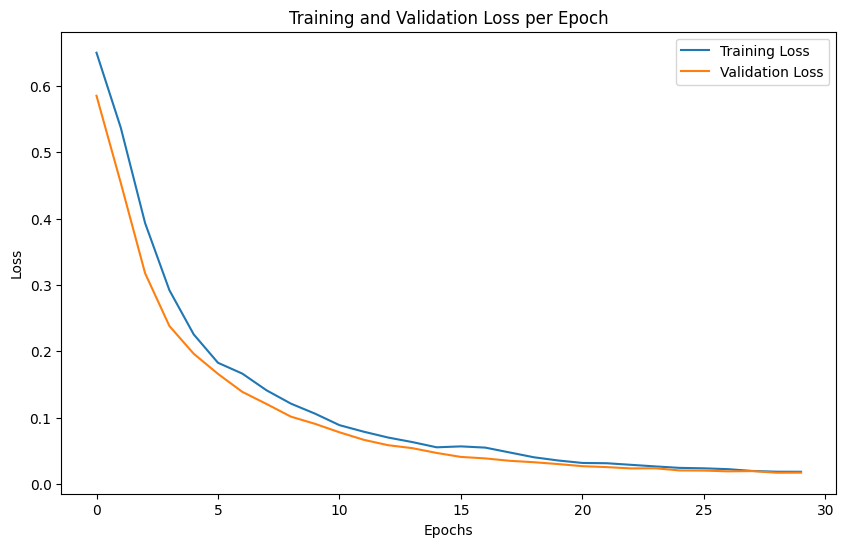

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

#load datat
data = pd.read_csv('/home/abdullah.zubair/test/data.csv')

def convert_to_binary(obesity_class):
    if obesity_class in ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I']:
        return 'Not Obese'
    else: # 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'
        return 'Obese'

data['NObeyesdad'] = data['NObeyesdad'].apply(convert_to_binary)

#encoding categorical variables
for column in data.select_dtypes(include=['object']).columns:
    data[column] = LabelEncoder().fit_transform(data[column])

#separating the features and the target variable
X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

#convert your target variable to numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#apply Mutual Information for feature selection
mi_selector = SelectKBest(mutual_info_classif, k=10)  # Adjust 'k' as needed
mi_selector.fit(X, y_encoded)
X_selected = mi_selector.transform(X)

#standardize the continuous features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

#splitting the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#create data loaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=64, shuffle=True)

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(10, 64)  # 10 features as input
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

model = BinaryClassifier()

#define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate

#early stopping parameters
patience = 5  # How many epochs to wait after last time validation loss improved
best_loss = float('inf')
trigger_times = 0  # Counter for early stopping

#new listss to track loss
train_losses = []
val_losses = []

for epoch in range(30):  # Number of epochs
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    average_train_loss = train_loss / len(train_loader)
    train_losses.append(average_train_loss)

    #validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)

    #print epoch information
    print(f'Epoch {epoch + 1}, Training Loss: {average_train_loss}, Validation Loss: {average_val_loss}')

    # Early stopping check
    if average_val_loss < best_loss:
        best_loss = average_val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

#plotting training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

summary(model, input_size=(1, 10))

model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64):
        outputs = model(inputs)
        predictions = outputs.squeeze().round()  # Round to get binary predictions
        y_pred.extend(predictions.numpy())
        y_true.extend(labels.numpy())

#convert predictions and true values to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Epoch 1, Training Loss: 0.581189494183723, Training Recall: 0.9441340782122905, Validation Loss: 0.44528067111968994, Validation Recall: 0.9213483146067416
Epoch 2, Training Loss: 0.3428152260628152, Training Recall: 0.9284916201117318, Validation Loss: 0.24979063868522644, Validation Recall: 0.9269662921348315
Epoch 3, Training Loss: 0.21624729124472497, Training Recall: 0.9463687150837988, Validation Loss: 0.1764146037399769, Validation Recall: 0.9662921348314607
Epoch 4, Training Loss: 0.16197166084609133, Training Recall: 0.9698324022346368, Validation Loss: 0.1290575310587883, Validation Recall: 0.9775280898876404
Epoch 5, Training Loss: 0.12709286698001496, Training Recall: 0.9687150837988827, Validation Loss: 0.0992130346596241, Validation Recall: 0.9887640449438202
Epoch 6, Training Loss: 0.10303286348588447, Training Recall: 0.9798882681564246, Validation Loss: 0.07528253495693207, Validation Recall: 0.9943820224719101
Epoch 7, Training Loss: 0.0824297749774253, Training Recal

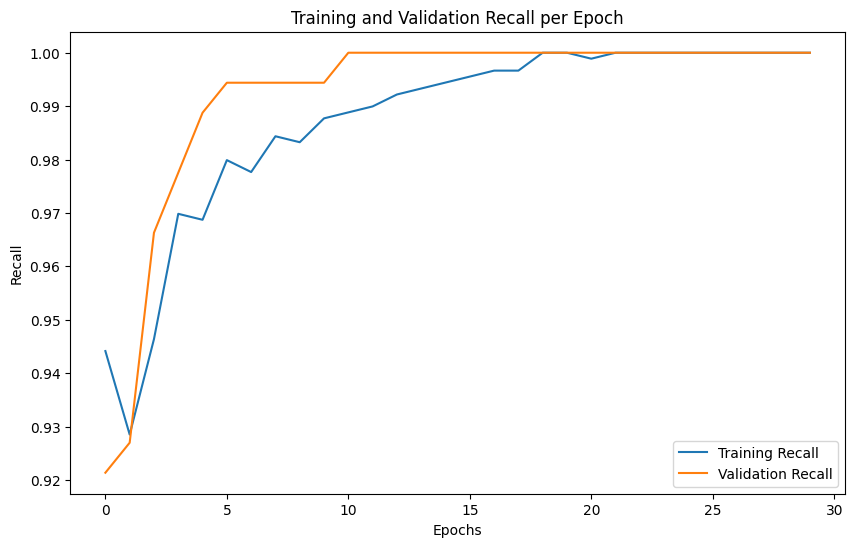

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

# Load the dataset
data = pd.read_csv('/home/abdullah.zubair/test/data.csv')

#convert the target variable into binary form
def convert_to_binary(obesity_class):
    if obesity_class in ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I']:
        return 'Not Obese'
    else: # 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III'
        return 'Obese'

data['NObeyesdad'] = data['NObeyesdad'].apply(convert_to_binary)

#encoding categorical variables
for column in data.select_dtypes(include=['object']).columns:
    data[column] = LabelEncoder().fit_transform(data[column])

#separating the features and the obesity metric
X = data.drop('NObeyesdad', axis=1)
y = data['NObeyesdad']

# Convert your target variable to numeric
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Apply Mutual Information for feature selection
mi_selector = SelectKBest(mutual_info_classif, k=10)  # Adjust 'k' as needed
mi_selector.fit(X, y_encoded)
X_selected = mi_selector.transform(X)

# Standardize the continuous features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Splitting the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create data loaders
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)

# Define the model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(10, 64)  # 10 features as input
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

model = BinaryClassifier()

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate

# Early stopping parameters
patience = 5  # How many epochs to wait after last time validation loss improved
best_loss = float('inf')
trigger_times = 0  # Counter for early stopping

# New lists to track recall
train_recalls = []
val_recalls = []

# Modified Training loop with recall tracking
for epoch in range(30):  # Number of epochs
    # Training phase
    model.train()
    train_loss = 0
    train_predictions = []
    train_true_labels = []
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        predicted = outputs.squeeze().round()
        train_predictions.extend(predicted.detach().numpy())
        train_true_labels.extend(labels.numpy())
    average_train_loss = train_loss / len(train_loader)
    train_recall = recall_score(train_true_labels, train_predictions)
    train_losses.append(average_train_loss)
    train_recalls.append(train_recall)

    # Validation phase
    model.eval()
    val_loss = 0
    val_predictions = []
    val_true_labels = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            predicted = outputs.squeeze().round()
            val_predictions.extend(predicted.detach().numpy())
            val_true_labels.extend(labels.numpy())
    average_val_loss = val_loss / len(val_loader)
    val_recall = recall_score(val_true_labels, val_predictions)
    val_losses.append(average_val_loss)
    val_recalls.append(val_recall)

    # Print epoch information
    print(f'Epoch {epoch + 1}, Training Loss: {average_train_loss}, Training Recall: {train_recall}, Validation Loss: {average_val_loss}, Validation Recall: {val_recall}')

    # Early stopping check
    if average_val_loss < best_loss:
        best_loss = average_val_loss
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break

# Plotting training and validation recall
plt.figure(figsize=(10, 6))
plt.plot(train_recalls, label='Training Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.title('Training and Validation Recall per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()